In [ ]:
# Install lap, required for SFSORT
%pip install numpy lap -q

#Install ultralytics to access the object detector
%pip install ultralytics -q

--- Logging error ---
Traceback (most recent call last):
  File "e:\Projects\ObjectTracking\.venv\lib\site-packages\pip\_internal\commands\install.py", line 377, in run
  File "e:\Projects\ObjectTracking\.venv\lib\site-packages\pip\_internal\resolution\resolvelib\resolver.py", line 179, in resolve
  File "e:\Projects\ObjectTracking\.venv\lib\site-packages\pip\_internal\operations\prepare.py", line 552, in prepare_linked_requirements_more
  File "e:\Projects\ObjectTracking\.venv\lib\site-packages\pip\_internal\operations\prepare.py", line 467, in _complete_partial_requirements
  File "e:\Projects\ObjectTracking\.venv\lib\site-packages\pip\_internal\network\download.py", line 168, in __call__
  File "e:\Projects\ObjectTracking\.venv\lib\site-packages\pip\_internal\network\download.py", line 117, in _http_get_download
  File "e:\Projects\ObjectTracking\.venv\lib\site-packages\pip\_vendor\requests\sessions.py", line 602, in get
  File "e:\Projects\ObjectTracking\.venv\lib\site-packages\pip

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
# Import essential libraries
import numpy as np
import cv2
from PIL import Image

from ultralytics import YOLO
from ultralytics.utils.torch_utils import select_device
from random import randrange

from SFSORT import SFSORT

WARNING  Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View settings with 'yolo settings' or at 'C:\Users\User\AppData\Roaming\Ultralytics\settings.yaml'
Update settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
# Instantiate an object detector
model = YOLO('weights/best.pt')

# Check for GPU availability
device = select_device('cpu')
# Devolve the processing to selected devices
model.to(device)

Ultralytics YOLOv8.2.28  Python-3.10.11 torch-2.3.1+cpu CPU (11th Gen Intel Core(TM) i5-11400H 2.70GHz)


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [15]:
# Load the video file
cap = cv2.VideoCapture('tanks.mp4')

In [16]:
# Get the frame rate, frame width, and frame height
frame_rate = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [17]:
# Define the MP4 codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_1.mp4', fourcc, 30.0, (frame_width, frame_height))

# Organize tracker arguments into standard format
tracker_arguments = {"dynamic_tuning": True, "cth": 0.2,
                      "high_th": 0.82, "high_th_m": 0.1,
                      "match_th_first": 0.5, "match_th_first_m": 0.05,
                      "match_th_second": 0.1, "low_th": 0.1,
                      "new_track_th": 0.2, "new_track_th_m": 0.1,
                      "marginal_timeout": (7 * frame_rate // 10),
                      "central_timeout": frame_rate,
                      "horizontal_margin": frame_width // 10,
                      "vertical_margin": frame_height // 10,
                      "frame_width": frame_width,
                      "frame_height": frame_height}

# Instantiate a tracker
tracker = SFSORT(tracker_arguments)

# Define a color list for track visualization
colors = {}
frame_count = 0

In [19]:
# Process each frame of the video
while cap.isOpened():
   # Load the frame
  ret, frame = cap.read()
  if not ret:
      break
  frame_count += 1
  print(f"predict frame # {frame_count}/{frame_length}")
  # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  # Detect people in the frame
  prediction = model.predict(frame, imgsz=(640,640), conf=0.1, iou=0.45,
                              half=False, device=device, max_det=99, classes=2,
                              verbose=False)

  # Exclude additional information from the predictions
  prediction_results = prediction[0].boxes.cpu().numpy()

  # Update the tracker with the latest detections
  tracks = tracker.update(prediction_results.xyxy, prediction_results.conf)

  # Skip additional analysis if the tracker is not currently tracking anyone
  print(f"Prediction results:\n{prediction_results.cls}\n{prediction_results.conf}\nTracks available: {len(tracks)}\n")
  if len(tracks) == 0:
      out.write(frame)
      continue

  # Extract tracking data from the tracker
  bbox_list = tracks[:, 0]
  track_id_list = tracks[:, 1]

  # Visualize tracks
  for idx, (track_id, bbox) in enumerate(zip(track_id_list, bbox_list)):
    # Define a new color for newly detected tracks
    if track_id not in colors:
        colors[track_id] = (randrange(255), randrange(255), randrange(255))

    color = colors[track_id]

    # Extract the bounding box coordinates
    x0, y0, x1, y1 = map(int, bbox)

    # Draw the bounding boxes on the frame
    annotated_frame = cv2.rectangle(frame, (x0, y0), (x1, y1), color, 2)
    # Put the track label on the frame alongside the bounding box
    cv2.putText(annotated_frame, str(track_id), (x0, y0-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)


  # Write the frame to the output video file
  out.write(annotated_frame)
# Release everything when done
cap.release()
out.release()

predict frame # 1/984
Prediction results:
[]
[]
Tracks available: 0

predict frame # 2/984
Prediction results:
[]
[]
Tracks available: 0

predict frame # 3/984
Prediction results:
[]
[]
Tracks available: 0

predict frame # 4/984
Prediction results:
[]
[]
Tracks available: 0

predict frame # 5/984
Prediction results:
[]
[]
Tracks available: 0

predict frame # 6/984
Prediction results:
[]
[]
Tracks available: 0

predict frame # 7/984
Prediction results:
[]
[]
Tracks available: 0

predict frame # 8/984
Prediction results:
[]
[]
Tracks available: 0

predict frame # 9/984
Prediction results:
[]
[]
Tracks available: 0

predict frame # 10/984
Prediction results:
[]
[]
Tracks available: 0

predict frame # 11/984
Prediction results:
[]
[]
Tracks available: 0

predict frame # 12/984
Prediction results:
[]
[]
Tracks available: 0

predict frame # 13/984
Prediction results:
[]
[]
Tracks available: 0

predict frame # 14/984
Prediction results:
[]
[]
Tracks available: 0

predict frame # 15/984
Predic

KeyboardInterrupt: 

In [20]:
cap.release()
out.release()

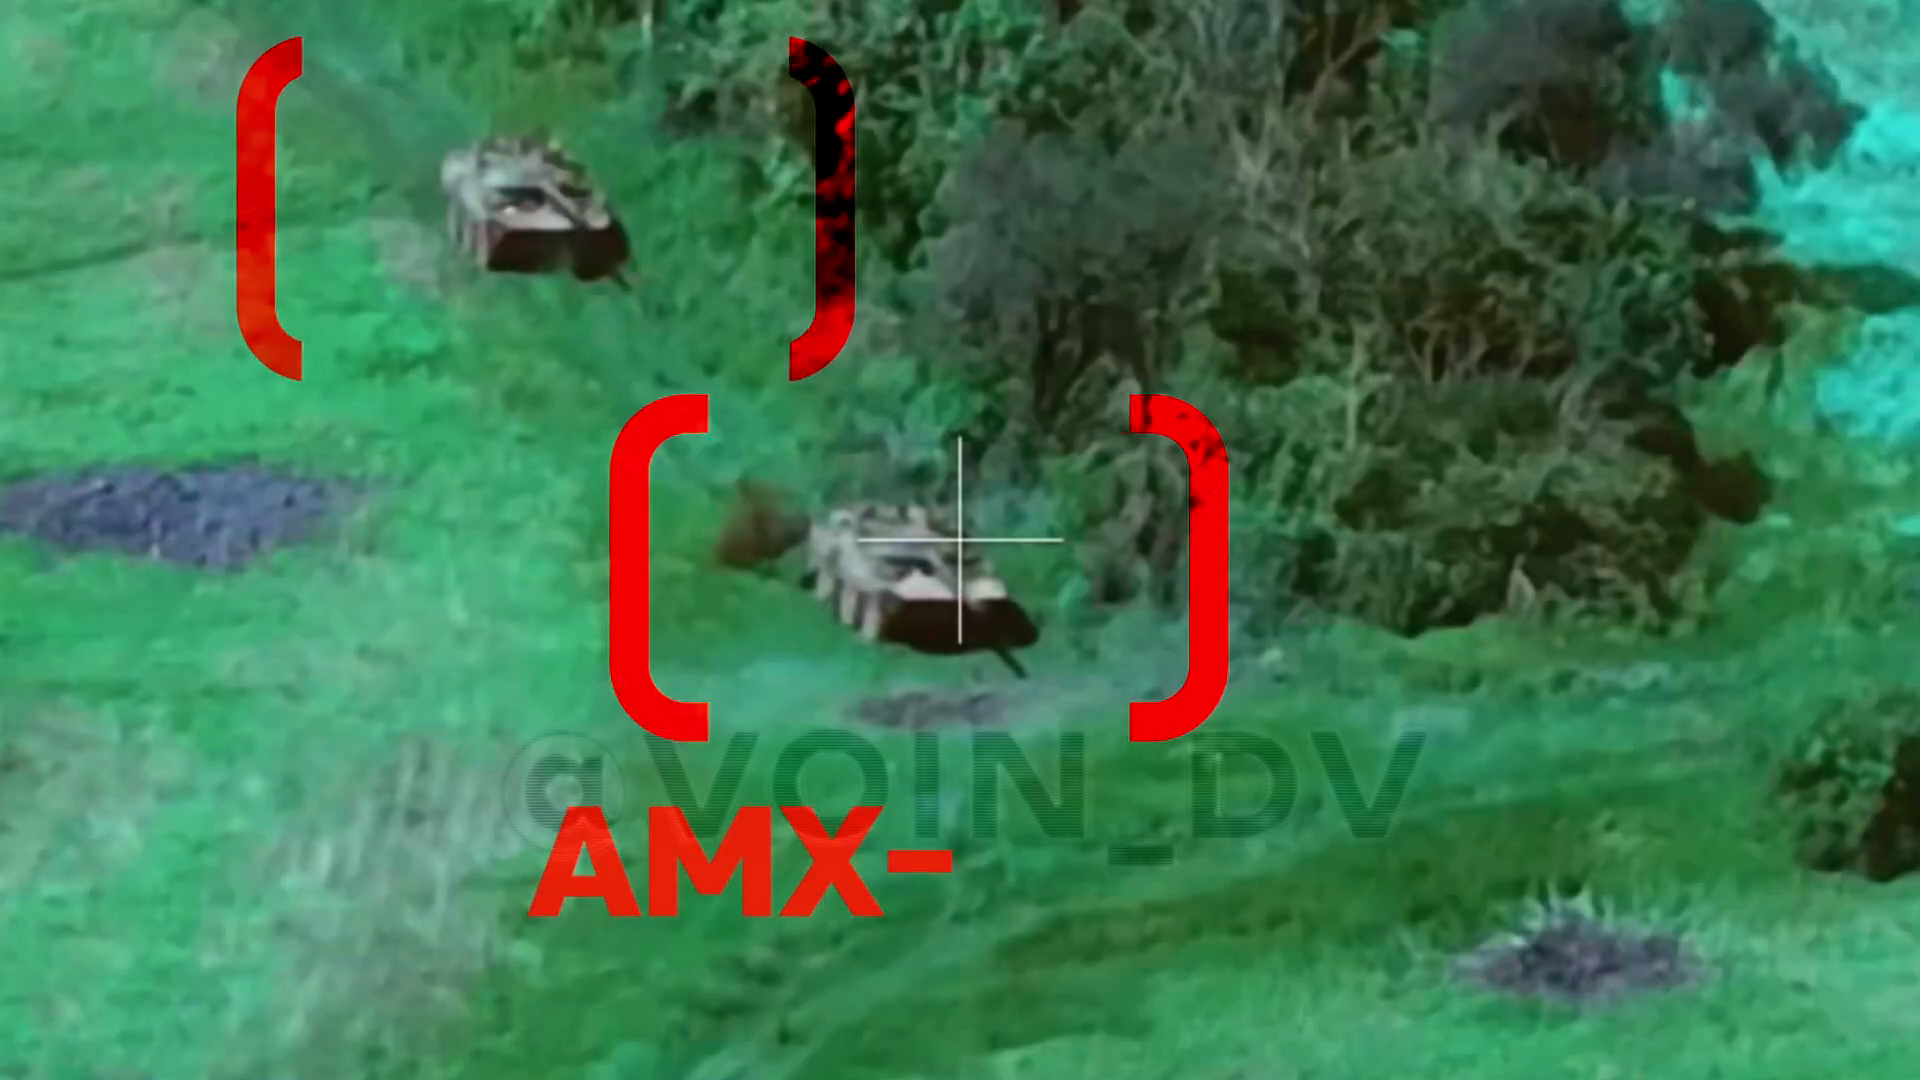

In [12]:
Image.fromarray(frame)

In [29]:
prediction[0].boxes.cpu().numpy()

ultralytics.engine.results.Boxes object with attributes:

cls: array([], dtype=float32)
conf: array([], dtype=float32)
data: array([], shape=(0, 6), dtype=float32)
id: None
is_track: False
orig_shape: (1080, 1920)
shape: (0, 6)
xywh: array([], shape=(0, 4), dtype=float32)
xywhn: array([], shape=(0, 4), dtype=float32)
xyxy: array([], shape=(0, 4), dtype=float32)
xyxyn: array([], shape=(0, 4), dtype=float32)

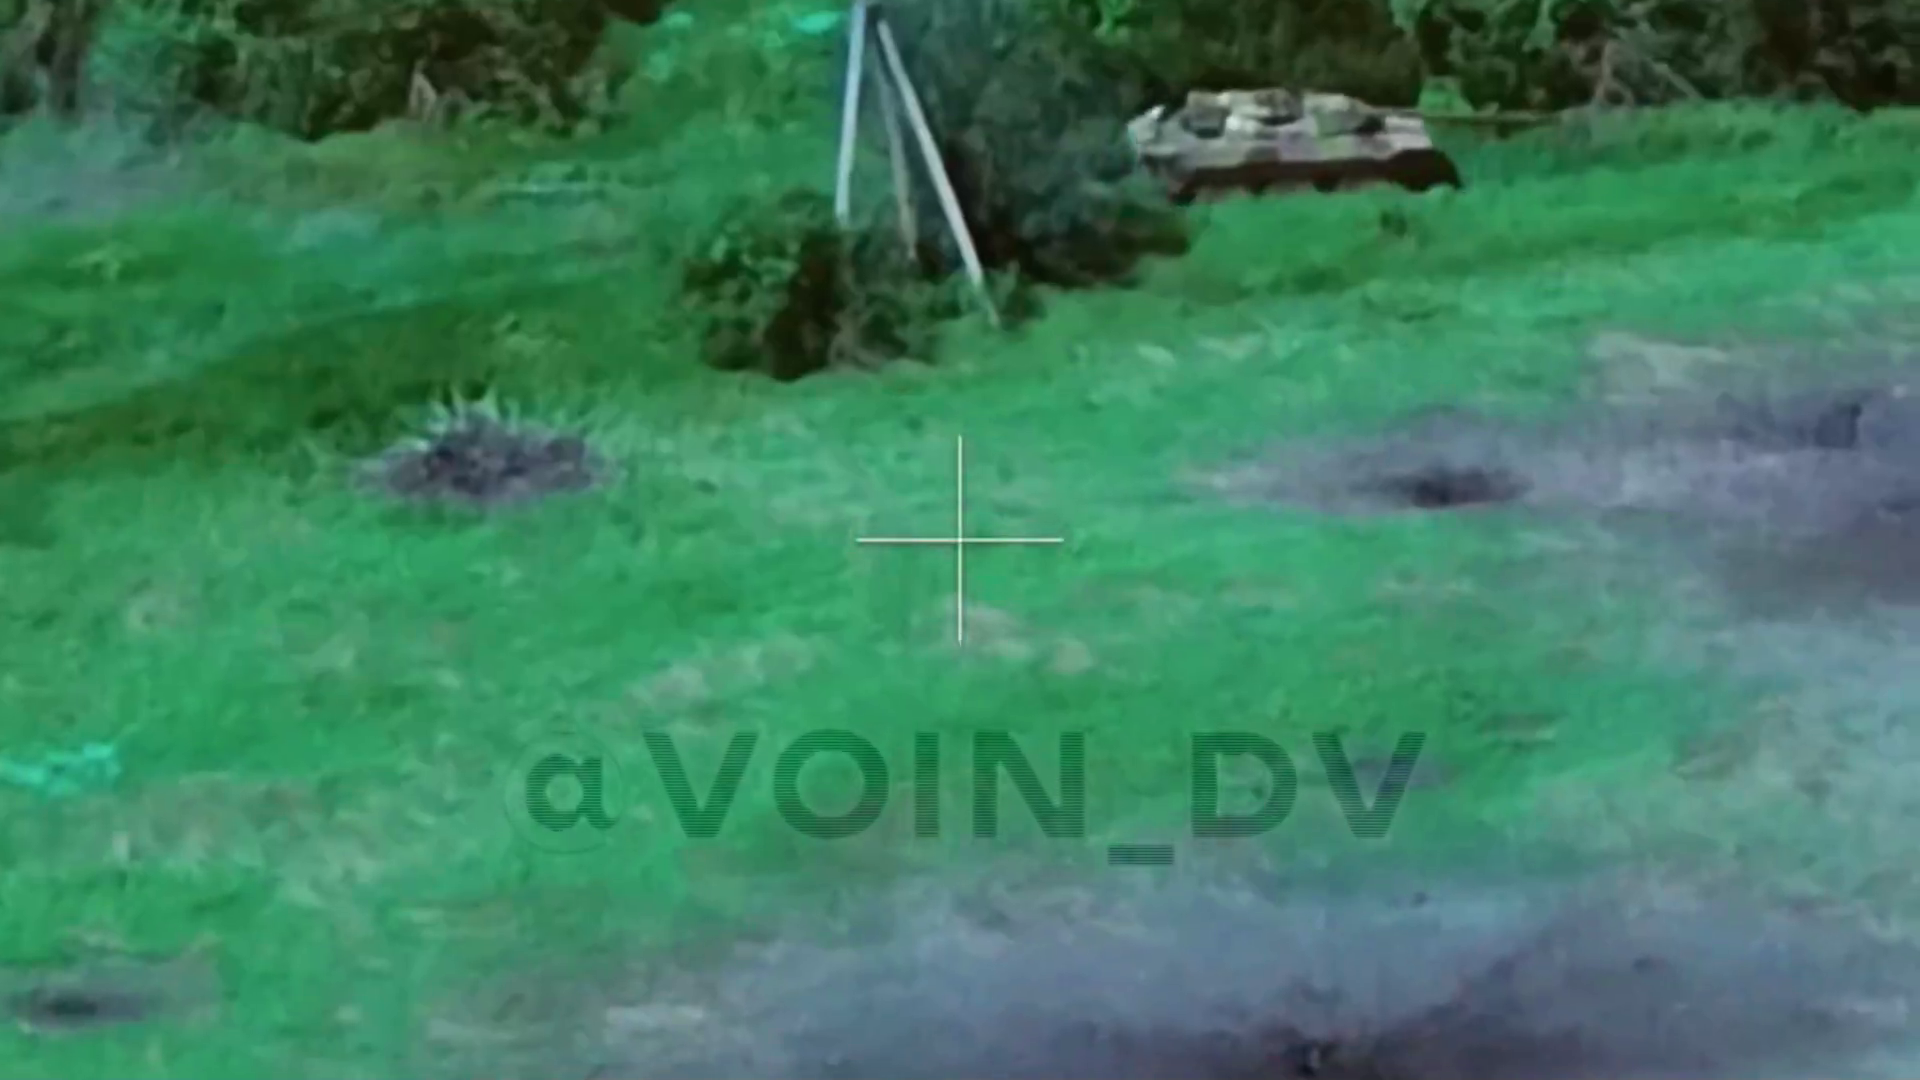

In [25]:
Image.fromarray(prediction[0].orig_img)